In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score

### Augmented Dicky Fuller test for staitionary data

In [2]:
def test_stationary(time_series):
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Reading and preparing data

In [3]:
df = pd.read_csv('Data Scientist test set.csv')
dfs = df.dropna().reset_index(drop=True)
dfs.head()

,date,sensor NO2,TEMP,RH,dewpoint,actual NO2
0,1/01/2018 8:00,22.4,8.4,67.5,2.7,30.0
1,1/01/2018 9:00,22.1,8.1,66.3,2.2,30.5
2,1/01/2018 10:00,22.5,7.6,65.2,1.5,29.0
3,1/01/2018 11:00,20.4,6.9,64.5,0.7,27.6
4,1/01/2018 12:00,21.6,6.5,62.1,-0.3,30.2


In [4]:
dfs['date'] = dfs['date'].apply(lambda x : pd.datetime.strptime(x, '%d/%m/%Y %H:%M'))

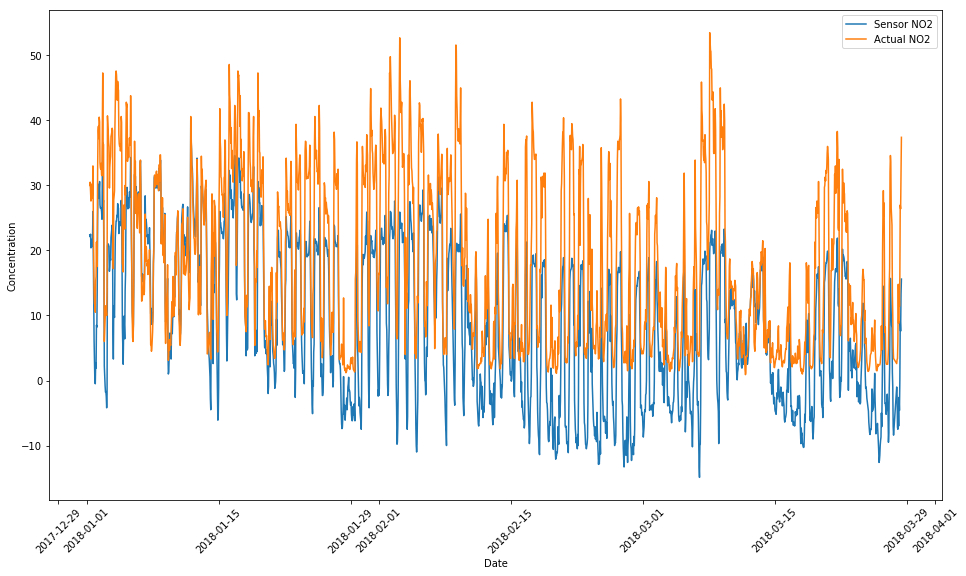

In [5]:
plt.figure(1, figsize=(16, 9))
plt.plot(dfs['date'], dfs['sensor NO2'], label='Sensor NO2')
plt.plot(dfs['date'], dfs['actual NO2'], label='Actual NO2')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.xticks(rotation=45)
plt.legend()

Figure 1 shows a misalignment between the actual NO2 concentrations and measured sensor data.
Root mean squared error (RMSE) and R-squared score (goodness of fit) are selected as metrics. 

In [6]:
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(dfs['actual NO2'], dfs['sensor NO2']))))
print('R-squared score: {0}'.format(r2_score(dfs['actual NO2'], dfs['sensor NO2'])))

RMSE: 11.048512905935851
R-squared score: 0.27994285045536327


Results show a poor fit and also relatively high error.

Text(0, 0.5, 'Sensor NO2')

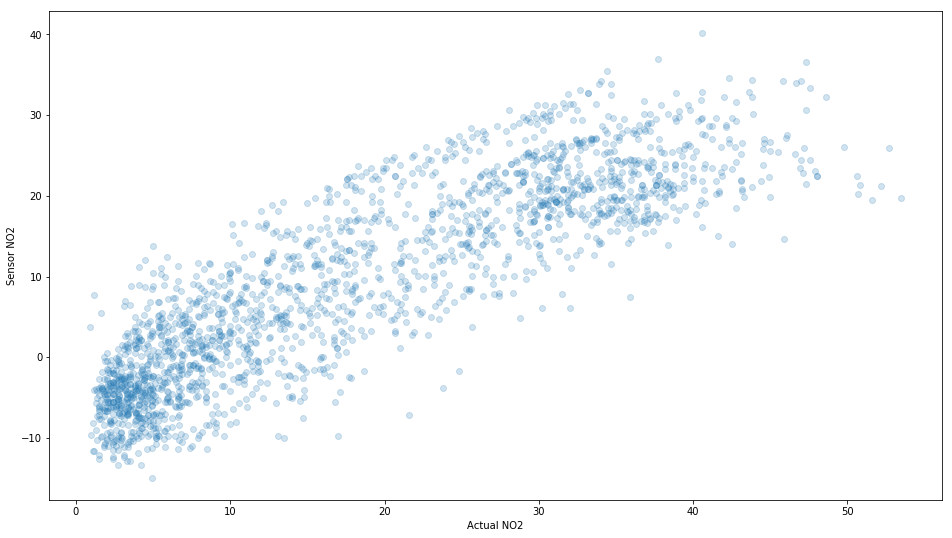

In [7]:
plt.figure(2, figsize=(16, 9))
plt.plot(dfs['actual NO2'], dfs['sensor NO2'], 'o', alpha=0.2)
plt.xlabel('Actual NO2')
plt.ylabel('Sensor NO2')

However, Figure 2 shows a linear pattern between the actual and measured data.

In [8]:
dfs.corr()

,sensor NO2,TEMP,RH,dewpoint,actual NO2
sensor NO2,1.000000,-0.247352,0.262720,0.268418,0.872751
TEMP,-0.247352,1.000000,-0.621633,-0.138974,-0.317293
RH,0.262720,-0.621633,1.000000,0.794806,0.076487
dewpoint,0.268418,-0.138974,0.794806,1.000000,0.012503
actual NO2,0.872751,-0.317293,0.076487,0.012503,1.000000


Actual and sensor data show a high correlation. Temperature is another feature that shows negative but relatively higher correlation with actual NO2 concentration, which could be selected as extra feature.
This is reasonable as according to ideal gas equation: PV = nRT and then n/V = C = P/RT

Also temperature is a calculated based on:
http://andrew.rsmas.miami.edu/Humidity.html

T=243.04*(((17.625*TD)/(243.04+TD))-LN(RH/100))/(17.625+LN(RH/100)-((17.625*TD)/(243.04+TD)))

where TD is dewpoint and RH is relative humidity. T and TD inputs/outputs to the equations are in Celsius.

Therefore there is a relationship between T and other parameters. WE could use all the features for the regression.

In [9]:
test_stationary(dfs['actual NO2'])

Results of Dickey-Fuller test:
Test Statistic                   -4.467415
p-value                           0.000225
#Lags Used                       25.000000
Number of Observations Used    2015.000000
Critical Value (1%)              -3.433599
Critical Value (5%)              -2.862975
Critical Value (10%)             -2.567534
dtype: float64


In [10]:
test_stationary(dfs['sensor NO2'])

Results of Dickey-Fuller test:
Test Statistic                   -3.743533
p-value                           0.003541
#Lags Used                       25.000000
Number of Observations Used    2015.000000
Critical Value (1%)              -3.433599
Critical Value (5%)              -2.862975
Critical Value (10%)             -2.567534
dtype: float64


In [11]:
test_stationary(dfs['TEMP'])

Results of Dickey-Fuller test:
Test Statistic                   -3.748353
p-value                           0.003482
#Lags Used                       26.000000
Number of Observations Used    2014.000000
Critical Value (1%)              -3.433601
Critical Value (5%)              -2.862976
Critical Value (10%)             -2.567535
dtype: float64


In [12]:
test_stationary(dfs['dewpoint'])

Results of Dickey-Fuller test:
Test Statistic                -5.798811e+00
p-value                        4.683155e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.038000e+03
Critical Value (1%)           -3.433563e+00
Critical Value (5%)           -2.862959e+00
Critical Value (10%)          -2.567526e+00
dtype: float64


In [13]:
test_stationary(dfs['RH'])

Results of Dickey-Fuller test:
Test Statistic                   -5.408084
p-value                           0.000003
#Lags Used                       26.000000
Number of Observations Used    2014.000000
Critical Value (1%)              -3.433601
Critical Value (5%)              -2.862976
Critical Value (10%)             -2.567535
dtype: float64


Augmented Dicky Fuller test results show that all varibles are stationary (p-value < 0.05). Therefore, the parameters of their distribution does not vary and a siple regression should be enough to model their variations.

### Linear regression

In [14]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [15]:
rgs = LinearRegression()

#### We divide the time series to training and test set. Test set is used for validating the predictions.

In [16]:
train = dfs[:1800]
test = dfs[1800:]

#### Fitting only on the training set

In [17]:
rgs.fit(train[['sensor NO2', 'TEMP', 'dewpoint', 'RH']], train['actual NO2'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
tr_pred = rgs.predict(train[['sensor NO2', 'TEMP', 'dewpoint', 'RH']])

In [19]:
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(train['actual NO2'], tr_pred))))
print('R-squared score: {0}'.format(r2_score(train['actual NO2'], tr_pred)))

RMSE: 5.1584212329619055
R-squared score: 0.8468720328403399


RMSE for estimating the training set is increased to 6.43 which is abput 53% reduction in error. R-squared increased significantly by 67%.

Lets see how the model works on unknown data.

In [20]:
ts_pred = rgs.predict(test[['sensor NO2', 'TEMP', 'dewpoint', 'RH']])

In [21]:
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(test['actual NO2'], ts_pred))))
print('R-squared score: {0}'.format(r2_score(test['actual NO2'], ts_pred)))

RMSE: 4.416068876767912
R-squared score: 0.8275332974899398


Error even decreased more and R-squared again increased. This indicates that the model is generalised well and does not overfit. 

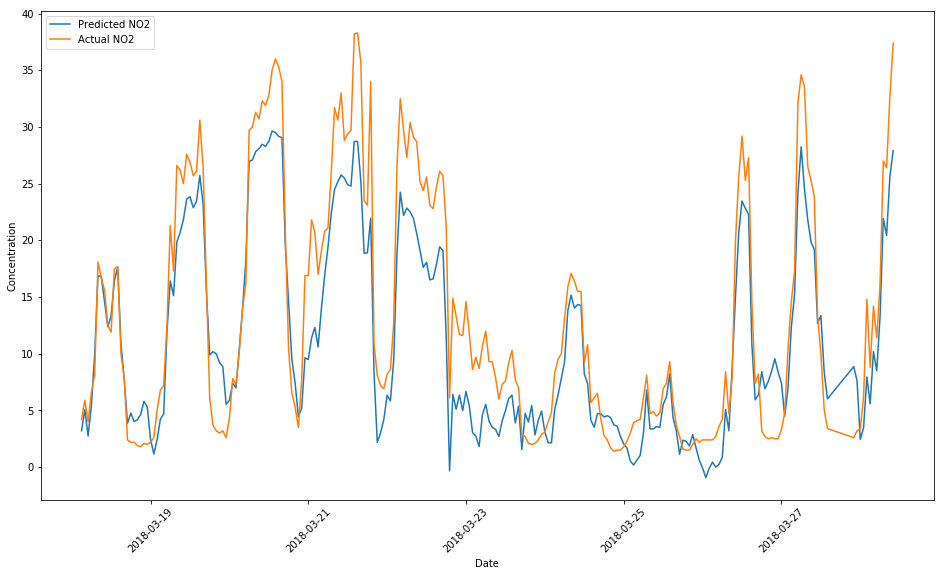

In [22]:
plt.figure(3, figsize=(16, 9))
plt.plot(test['date'], ts_pred, label='Predicted NO2')
plt.plot(test['date'], test['actual NO2'].reset_index(drop=True), label='Actual NO2')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.xticks(rotation=45)
plt.legend()

Figure 3 shows a better match between the actual NO2 and predicted one for the test set.

In [23]:
pred_s = pd.Series(ts_pred)

In [24]:
pred_s.index = test.index

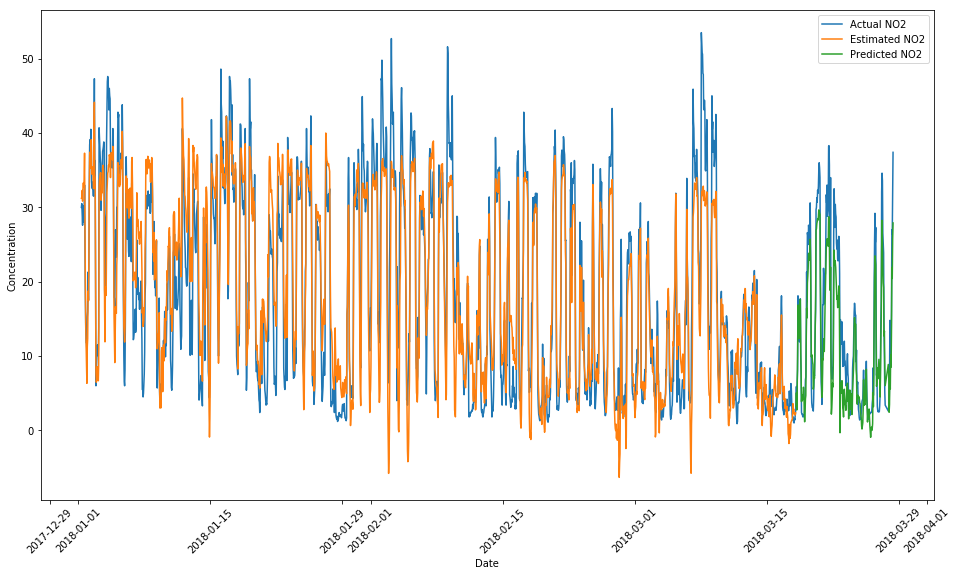

In [25]:
plt.figure(4, figsize=(16, 9))
plt.plot(dfs['date'], dfs['actual NO2'], label='Actual NO2')
plt.plot(train['date'], tr_pred, label='Estimated NO2')
plt.plot(test['date'], ts_pred, label='Predicted NO2')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.xticks(rotation=45)
plt.legend()

Having a look at the new msensor estimate, we can see that it now better matches with actual NO2 concentration, both for known and unknown future data.

Now let's have a look at the model parameters:

In [26]:
rgs.coef_

array([ 0.95709064, -0.70258545,  0.09217418, -0.22007242])

In [27]:
rgs.intercept_

30.292550337186114

We can now estimate the concentration as a new estimate according to the equation below:

#### Actual NO2 = rgs.coef_0 x Sensor NO2 + rgs.coef_1 x TEMP + rgs.coef_2 x dewpoint + rgs.coef_3 x RH + rgs.intercept_

It is possible to increase the accuracy by tuning the hyper-parameters of the model and also introducing penalties for higher errors. (L1 or L2 regularization)